## 6614450115 PATCHARAPORN SOPONPONG

## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [9]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [10]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[]

In [12]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [13]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #dataset,cifar จะส่งข้อมูล train and test , y จะเป็นค่า 0-9
print('x_train shape:', x_train.shape) 
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# 10 class samples = 1000 --> ค่าประมาณของ accuracy = 900/1000

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
x_test.shape

(10000, 32, 32, 3)

In [16]:
np.unique(y_test,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
## Each image is a 32 x 32 x 3 numpy array
#cifar10 มีขนาด 32x32
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


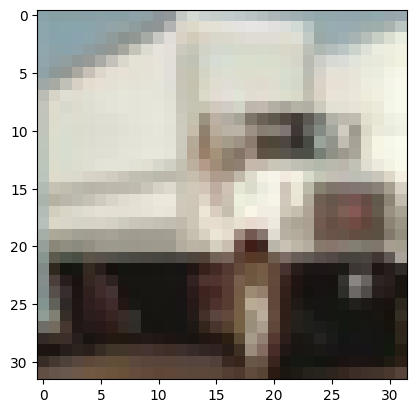

In [7]:
## Let's look at one of the images

image_no = 444 #ภาพที่
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [8]:
#ในความเป็นจริงไม่ควรตั้งค่า class เป็นตัวเลข 0-9 เลยต้องทำการแปลงเพื่อลดการ bias

In [9]:
num_classes = 10 

y_train = keras.utils.to_categorical(y_train, num_classes) #แปลงเป็น one in.. 
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [11]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32') #x ข้อมูล test , y ผลเฉลย
x_test = x_test.astype('float32')
x_train /= 255 #การแปลงเป็น pixel 
x_test /= 255 #การแปลงเป็น pixel 

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [12]:
#set ค่า seed มีอิทธิพลในการ ramdom parameter --> ค่าramdom มา innitulrize -->ให้ค่าอยู่ในลักษณะเดิมตลอด
#ในการใช้การ์ดจอรันทำให้การรันแต่ครั้งจะไม่เหมือนกันเพราะการ์ดจอมีการแจกจ่ายงาน ถ้าอยากให้เท่ากันทุกรอบต้องใช้ cpu ในการรัน 
set_seed(12345) 


# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                        

2023-08-09 23:07:29.160216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We still have 181K parameters, even though this is a "small" model.


In [13]:
batch_size = 32 #ปรับได้ 32,64,128
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)
# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt, #สามารถเปลี่ยนเป็น opt-->adum
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 21s 12ms/step - loss: 1.7444 - accuracy: 0.3645 - val_loss: 1.5302 - val_accuracy: 0.4486
Epoch 2/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.4488 - accuracy: 0.4762 - val_loss: 1.3482 - val_accuracy: 0.5195
Epoch 3/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.3448 - accuracy: 0.5213 - val_loss: 1.2690 - val_accuracy: 0.5564
Epoch 4/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.2781 - accuracy: 0.5446 - val_loss: 1.2294 - val_accuracy: 0.5589
Epoch 5/10
1563/1563 [==============================] - 18s 11ms/step - loss: 1.2319 - accuracy: 0.5630 - val_loss: 1.1520 - val_accuracy: 0.5985
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1965 - accuracy: 0.5803 - val_loss: 1.1057 - val_accuracy: 0.6138
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1695 - accuracy: 0.5892 - val_loss: 1.1049 -

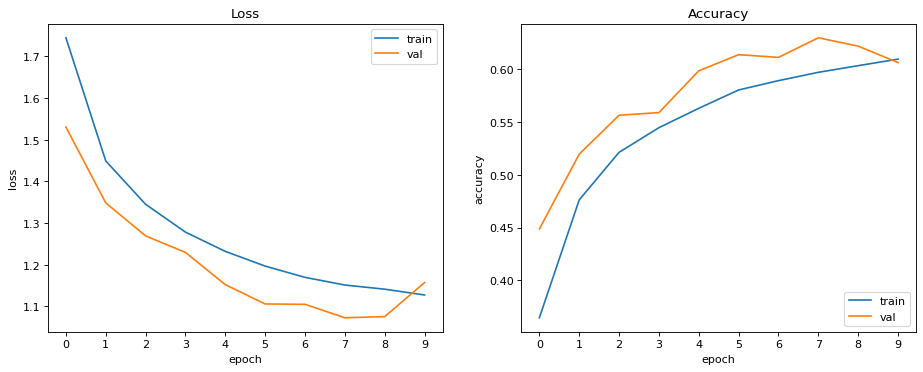

In [14]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [15]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 1.061234, Accuracy: 0.637240
 Test Loss: 1.157046, Accuracy: 0.606300

[[658  10  94  14  34   9   5  15  86  12]
 [ 51 778  26  29   8  27  12   7  80 109]
 [ 14   1 260  33  19  24  15   8   3   4]
 [  8   4  50 310  29 149  24  26   6   5]
 [ 31   3 213 104 604  86  51  76   9  10]
 [  5   1  64 135  23 394  10  45   3   5]
 [ 31  14 160 216 128 140 852  43  15  13]
 [ 23   6  76  71 121 114  10 718  12  20]
 [ 65   9  20  22  12  18   5   4 680  13]
 [114 174  37  66  22  39  16  58 106 809]]


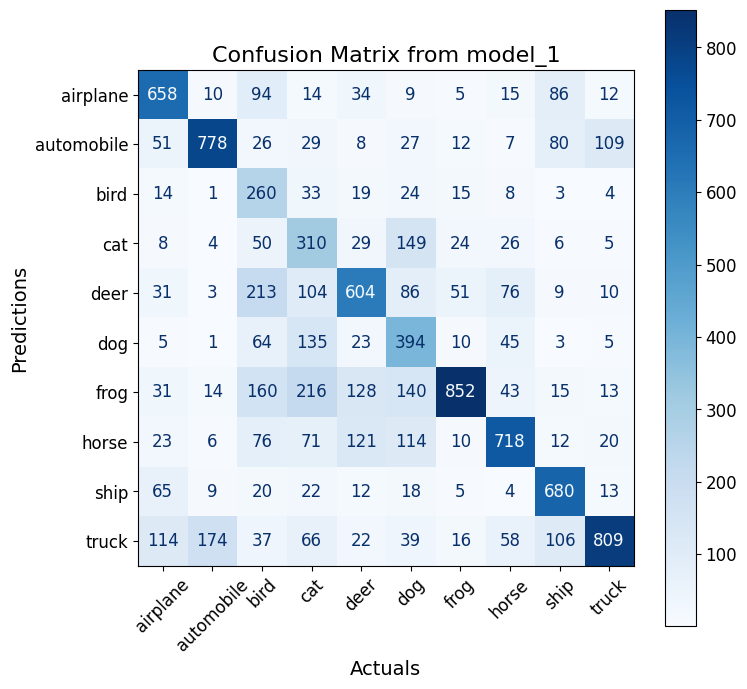

In [16]:
#confusion matrix (row=ค่าจริง,col=ค่าทำนาย)
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [17]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.70      0.66      0.68      1000
  automobile       0.69      0.78      0.73      1000
        bird       0.68      0.26      0.38      1000
         cat       0.51      0.31      0.38      1000
        deer       0.51      0.60      0.55      1000
         dog       0.58      0.39      0.47      1000
        frog       0.53      0.85      0.65      1000
       horse       0.61      0.72      0.66      1000
        ship       0.80      0.68      0.74      1000
       truck       0.56      0.81      0.66      1000

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.59     10000
weighted avg       0.62      0.61      0.59     10000



$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. (40 คะแนน) ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
- Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

- ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. (20 คะแนน) เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. (20 คะแนน) จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. (20 คะแนน) หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

### 1.(40 คะแนน) ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:

Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation


model_new = Sequential()                           #modelแบบลำดับขั้นตอน
model_new.add(Conv2D(32, (5, 5), strides = (1,1),  
                     padding='same', input_shape=x_train.shape[1:])) #conv =filter
model_new.add(Activation('relu'))                  #activation = relu
model_new.add(Conv2D(32, (5, 5), strides = (1,1))) #conv = filter
model_new.add(Activation('relu'))                  #activation =relu
model_new.add(MaxPooling2D(pool_size=(2, 2)))      #maxpool

model_new.add(Conv2D(32, (5, 5), strides = (1,1),
                     padding='same', input_shape=x_train.shape[1:])) #conv = filter
model_new.add(Activation('relu'))                    #activation = relu    

model_new.add(Conv2D(32, (5, 5), strides = (1,1)))   #conv = filter
model_new.add(Activation('relu'))                    #activation = relu 
model_new.add(MaxPooling2D(pool_size=(2, 2)))        #maxpool

model_new.add(Flatten())                             #Flatten
model_new.add(Dense(512))                            #Dense = hidden layter จำนวนโหนดใน model 
model_new.add(Activation('relu'))
model_new.add(Dense(num_classes))                    #final classification(จากของอาจารย์กำหนดค่า num_classes = 10 ตามโจทย์)
model_new.add(Activation('softmax'))
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        25632     
                                                      

### 2. (20 คะแนน) เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

In [19]:
batch_size = 32
opt = keras.optimizers.RMSprop(learning_rate=0.0005)
model_new.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_new = model_new.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)
#1563 มาจากจำนวนข้อมูลหารด้วย batch_size ex 50,000/32

Epoch 1/10
1563/1563 [==============================] - 152s 97ms/step - loss: 1.5416 - accuracy: 0.4424 - val_loss: 1.3150 - val_accuracy: 0.5316
Epoch 2/10
1563/1563 [==============================] - 151s 97ms/step - loss: 1.1222 - accuracy: 0.6043 - val_loss: 1.0163 - val_accuracy: 0.6446
Epoch 3/10
1563/1563 [==============================] - 157s 101ms/step - loss: 0.9178 - accuracy: 0.6807 - val_loss: 0.9327 - val_accuracy: 0.6849
Epoch 4/10
1563/1563 [==============================] - 155s 99ms/step - loss: 0.7907 - accuracy: 0.7271 - val_loss: 0.8944 - val_accuracy: 0.6911
Epoch 5/10
1563/1563 [==============================] - 162s 104ms/step - loss: 0.6986 - accuracy: 0.7590 - val_loss: 0.8541 - val_accuracy: 0.7076
Epoch 6/10
1563/1563 [==============================] - 158s 101ms/step - loss: 0.6304 - accuracy: 0.7845 - val_loss: 0.8509 - val_accuracy: 0.7266
Epoch 7/10
1563/1563 [==============================] - 212s 135ms/step - loss: 0.5709 - accuracy: 0.8032 - val_los

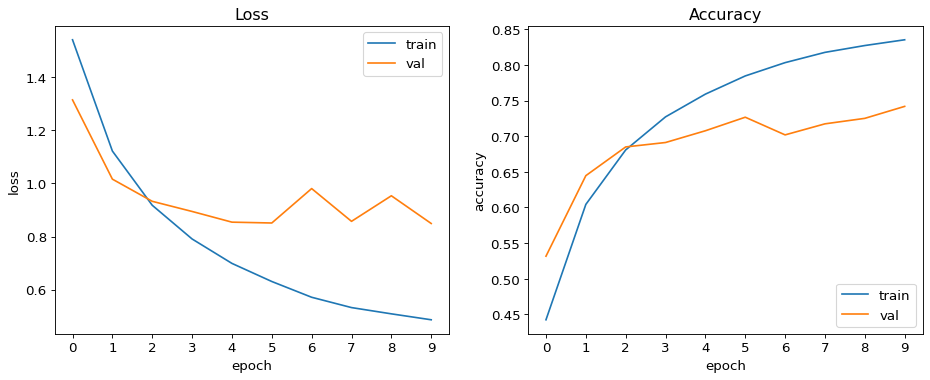

In [20]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_new.history['loss'])
ax.plot(history_new.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_new.history['accuracy'])
ax.plot(history_new.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

##### อธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส
    จากการทดลองสร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้น(model_new)เปรียบเทียบที่ 10 epochs (เท่ากับการเทรนโมเดลเดิม)
    สังเกตได้ว่ามีผลกระทบกับ 3 ด้านคือ 1.เวลา 2.ค่า Loss 3.ค่า Accuracy
    
    1.เวลา : โมเดลที่มีความซับซ้อนมากขึ้น(model_new)ใช้เวลาการเทรนนานขึ้น เนื่องจากมีจำนวนพารามิเตอร์ที่มากขึ้น ส่งผลให้ความแม่นยำของโมเดลมากขึ้น
    
    2.ค่า Loss และ Accuracy: 
        - จากกราฟของ loss ที่ epoch ที่ 9 ของโมเดลเดิม มีค่าประมาณ 1.2 
          จากกราฟของ loss ที่ epoch ที่ 9 ของโมเดลใหม่ ต่ำกว่า 0.6
        จะเห็นได้ว่าโมเดลใหม่ที่มีความซับซ้อนของโมเดลมีค่า loss ที่น้อยกว่าโมเดลเดิม
        - จากกราฟของ accuracy ที่ epoch ที่ 9 ค่าประมาณ 0.6
          จากกราฟของ accuracy ที่ epoch ที่ 9 ค่าประมาณ 0.83
        จะเห็นได้ว่าโมเดลใหม่ที่มีความซับซ้อนของโมเดลมีค่า accuracy มากกว่าโมเดลเดิม
        - จากกราฟทั้ง 2 ตั้งข้อสังเกตที่ 1 ได้ว่า กราฟค่า loss และค่า accuracy หลังจากผ่านไป 10 epochs แล้ว เส้น validation loss ก็ยังลดลงได้ไม่เท่า train loss ส่งผลให้กราฟ accuracy หลังจากผ่านไป 10 epochs แล้ว validation accuracy ก็ยังสูงได้ไม่เท่า train accuracy
        - จากกราฟทั้ง 2 ตั้งข้อสังเกตที่ 2 โมเดลที่มีความซับซ้อนมากขึ้นมีค่า loss ที่ลดลงและค่า accuracy ที่สูงขึ้นหลังจากผ่านไป 10 epochs ทั้งในชุดข้อมูลเทรนและทดสอบ หมายถึงความสามารถในการเรียนรู้และทำนายข้อมูลของโมเดลที่มากขึ้น 
        สรุปได้ว่าเมื่อมี epoch ที่จำนวนมากพอหรือเหมาะสมจะทำให้โมเดลเทรนได้จนมีผลเทรนที่ดีและโครงสร้างโมเดลที่มีความซับซ้อนมากขึ้น ที่เหมาะสมกับข้อมูลที่รับเข้ามาก็มีผลต่อผลการเทรนที่ดีขึ้น

### 3. (20 คะแนน) จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report


In [21]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_new.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_new.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_new.predict(x_test, verbose=0)

y_test_new = np.argmax(y_test, axis=1)
y_pred_new = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true=y_test_new, y_pred=y_pred_new).T
print(cm)

Train Loss: 0.399451, Accuracy: 0.863240
 Test Loss: 0.849038, Accuracy: 0.741800

[[745  13  59  22  13   9  10  21  42  23]
 [ 15 856   5  13   0   5   3   5  13  69]
 [ 41   0 624  62  50  51  23  32  10   5]
 [ 18   3  58 571  46 200  35  28   8  10]
 [ 20   5  84  88 737  57  37  71   4   5]
 [  3   2  27  74  17 523   8  19   3   1]
 [ 19  10  81  96  69  74 855  21   5  15]
 [  9   3  24  34  50  53   6 786   4   8]
 [103  41  32  24  15  22  21   8 892  35]
 [ 27  67   6  16   3   6   2   9  19 829]]


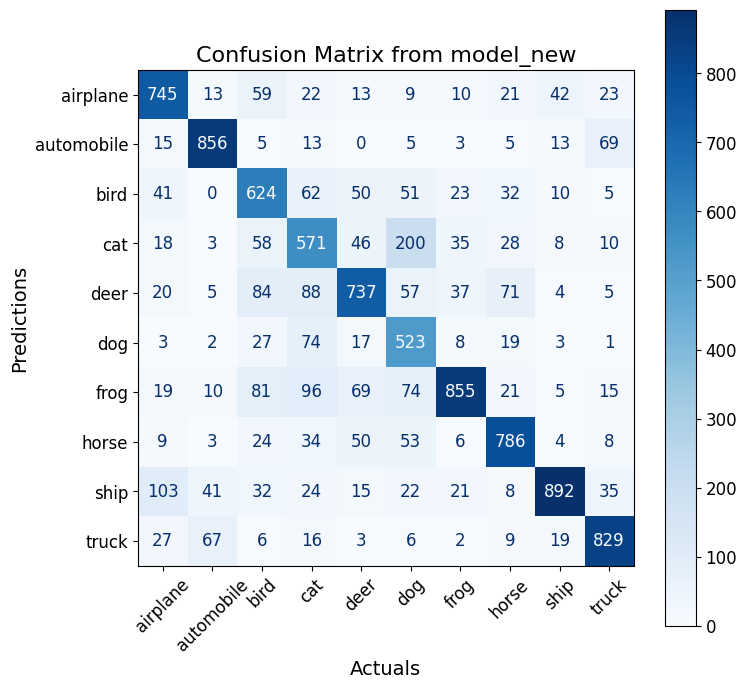

In [22]:
#Graph Confusion Matrix 
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title('Confusion Matrix from model_new', fontsize=16)
plt.show()


 Classification report

In [23]:
#classification report
np.set_printoptions(precision=2)
print(classification_report(y_true=y_test_new, y_pred=y_pred_new, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.78      0.74      0.76      1000
  automobile       0.87      0.86      0.86      1000
        bird       0.69      0.62      0.66      1000
         cat       0.58      0.57      0.58      1000
        deer       0.67      0.74      0.70      1000
         dog       0.77      0.52      0.62      1000
        frog       0.69      0.85      0.76      1000
       horse       0.80      0.79      0.80      1000
        ship       0.75      0.89      0.81      1000
       truck       0.84      0.83      0.84      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



### 4. (20 คะแนน) หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

In [24]:
y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)

In [25]:
# ผลเฉลยของภาพที่ 796 >> automobile
real_class = class_names[y_test_1d[796]]
print(real_class)

automobile


In [26]:
# โมเดลทำนายภาพที่ 796 >> deer เป็นการทำนายผิด
model_predict_class = class_names[y_pred_1d[796]]
print(model_predict_class)

deer


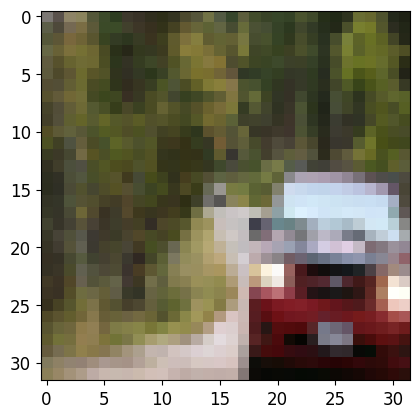

In [27]:
plt.imshow(x_test[796]);

#### สรุปได้ว่าภาพที่ 769 ผลเฉลยจาก class คือ automobile แต่โมเดลทำนายผิดเป็น deer

note

y test --> ตัวเลข --> เอาตัวเลขไปแทน classname ว่าเป็น class อะไร

y predict --> class อะไร

# จากสูตรการหา Recall
 $$ Recall = {TruePositives \over TruePositives + FalseNegatives} $$ 

    ถ้าแกน x = actual , y = prediction
    TruePositives = ค่าที่ทายถูก
    FlaseNegatives = ทั้งหมดที่ทายผิดรวมกัน 
    เช่น ของ truck ทำนายถูก 829 และค่าทั้งหมด = 1000
    จะได้ 829 / 1000